# Motivation

Pairs trading is a common statistical arbitrage strategy which posits that stocks with similar fundamentals (such as BHP and Rio Tinto for example) should maintain a constant price ratio over time. It trades on divergences from this ratio by going short/long on the spread, betting that the market will soon find one of the stocks overvalued and the other undervalued. These trades are thus 'market neutral' meaning that at any given time, the portfolio isn't exposed to movements of the wider share market which smooths return profiles.

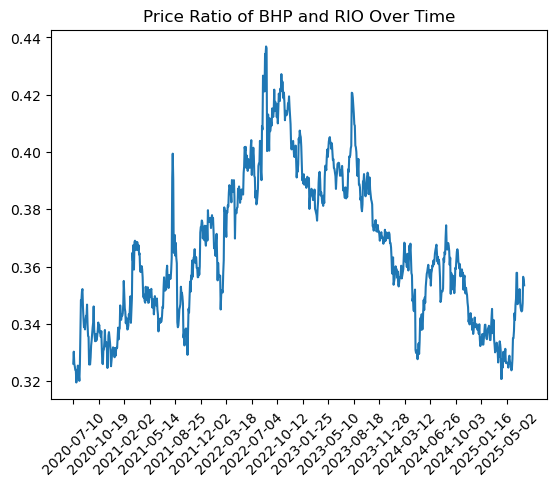

In [ ]:
#Exemplar mean reverting price ratin of BHP and Rio Tinto

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Data/ibkr_stocks1/BHPRIO.csv')
df['date'] = df['date'].apply(lambda x: x.split(' ')[0])
plt.plot(df['date'][::10], df['ratio'][::10])
plt.xticks(df['date'][::500], rotation=45)
plt.title('Price Ratio of BHP and RIO Over Time')
plt.show()

#
#
#
#
#
#
#
#
#
#
# Data

5 years of historical, hourly trade price data of large market cap pairs were scraped from Interactive Brokers. Data on the pairs' historical earnings release dates and ex-dividend dates were also collected from EODHD API. Only large market cap stocks were considered due to bid-ask spread.

In [2]:
#Considered Pairs

australian_pairs = [
    "CBAWBC",   # Commonwealth Bank and Westpac
    "BHPRIO",   # BHP and Rio Tinto
]

In [3]:
#Prices

df = pd.read_csv('Data/ibkr_stocks1/BHPRIO.csv')
df[['date', 'BHP','RIO','ratio']]

,date,BHP,RIO,ratio
0,2020-07-10 10:00:00+10:00,32.465,99.550,0.326118
1,2020-07-10 11:00:00+10:00,32.260,98.100,0.328848
2,2020-07-10 12:00:00+10:00,32.275,97.690,0.330382
3,2020-07-10 13:00:00+10:00,32.315,97.610,0.331062
4,2020-07-10 14:00:00+10:00,32.375,98.130,0.329919
...,...,...,...,...
8836,2025-07-08 12:00:00+10:00,38.060,107.670,0.353488
8837,2025-07-08 13:00:00+10:00,38.145,107.900,0.353522
8838,2025-07-08 14:00:00+10:00,38.040,107.710,0.353171
8839,2025-07-08 15:00:00+10:00,38.190,107.995,0.353627


In [4]:
#Historical Earnings and Ex-Dividend Dates Collected By Pair

import json

# Load existing earnings dates
with open('Data/earnings_dates1.json', 'r') as f:
    earnings_dates_dict = json.load(f)
    # Combine 'V' and 'MA' list values into one list and assign to 'VMA'
    earnings_dates_dict['VMA'] = earnings_dates_dict.get('V', []) + earnings_dates_dict.get('MA', [])    
    # Combine 'PEP' and 'KO' list values into one list and assign to 'PEPKO'
    earnings_dates_dict['PEPKO'] = earnings_dates_dict.get('PEP', []) + earnings_dates_dict.get('KO', [])


earnings_dates_dict

{'CBAWBC': ['2020-02-19',
  '2020-08-19',
  '2021-02-16',
  '2021-08-17',
  '2022-02-16',
  '2022-08-17',
  '2023-02-22',
  '2023-08-16',
  '2024-02-21',
  '2024-08-21',
  '2025-02-19',
  '2020-02-11',
  '2020-05-11',
  '2020-08-11',
  '2020-11-10',
  '2021-02-10',
  '2021-05-11',
  '2021-08-10',
  '2021-11-16',
  '2022-02-08',
  '2022-05-11',
  '2022-08-10',
  '2022-11-16',
  '2023-02-15',
  '2023-05-08',
  '2023-08-09',
  '2023-11-13',
  '2024-02-13',
  '2024-05-07',
  '2024-08-13',
  '2024-11-29',
  '2025-02-12',
  '2025-05-30',
  '2020-11-11',
  '2021-05-13',
  '2021-11-05',
  '2022-05-19',
  '2022-11-17',
  '2023-05-11',
  '2023-11-09',
  '2024-05-09',
  '2024-11-07',
  '2025-05-08',
  '2020-02-18',
  '2020-05-03',
  '2020-08-17',
  '2020-11-01',
  '2021-02-16',
  '2021-05-02',
  '2021-08-16',
  '2021-10-31',
  '2022-02-02',
  '2022-05-08',
  '2022-08-16',
  '2022-11-05',
  '2023-02-16',
  '2023-05-08',
  '2023-08-21',
  '2023-11-06',
  '2024-03-27',
  '2024-05-05',
  '2024-08-18'

#
#
#
#
#
#
#
#
#
#
# Strategy

1. A one parameter, custom mean reversion trading algorithm is applied to the price ratio of each pair. See appendix section below for algorithm details. 0.5% average loss on bid/ask spread and fees per transaction is assumed.
2. The algorithm is halted 2 days before earnings and ex-dividend dates and resumed from scratch 2 days afterwords to avoid associated momentum affects.
3. Parameter optimisation: Simulate trading portoflios for different algorithm parameters on all considered pairs over the training period. Select parameter with highest % return per trade.
4. Testing: Simulate trading portfolio on test dataset using selected parameter. 

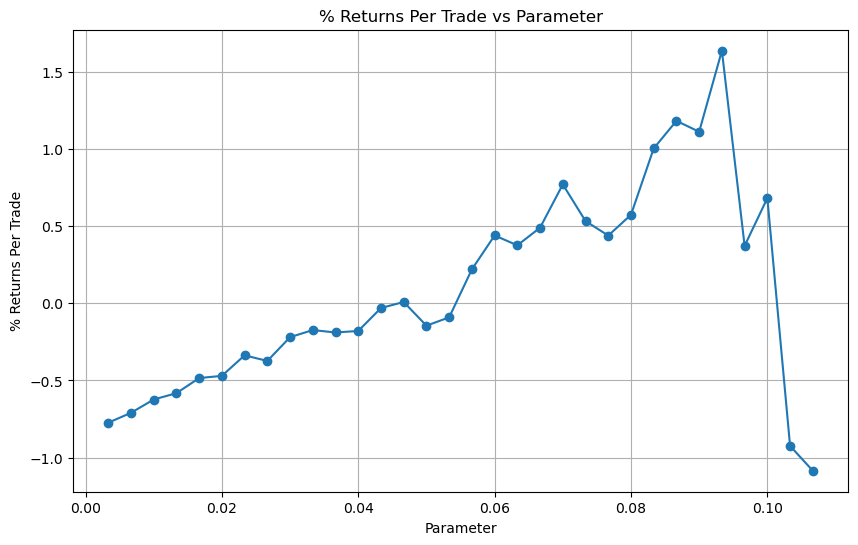

In [5]:
#Parameter optimisation

from Trading_Python_Functions import prepare_pairs_data, pair_sim, combine_pair_sims
import matplotlib.pyplot as plt
import numpy as np
import warnings


warnings.filterwarnings("ignore")
train_years = [2020,2021,2022,2023]

pairs_sim_data, pairs_dates_data =  prepare_pairs_data(australian_pairs, earnings_dates_dict)
pnls = []
ratio_retreats = []
for ratio_retreat in range(1,42):
    ratio_retreat = ratio_retreat/300
    pnl = combine_pair_sims(False, pairs_dates_data, pairs_sim_data, ratio_retreat, train_years)
    pnls.append(pnl)
    ratio_retreats.append(ratio_retreat)

plt.figure(figsize=(10, 6))
plt.plot(ratio_retreats, pnls, marker='o')
plt.xlabel('Parameter')
plt.ylabel('% Returns Per Trade')
plt.title('% Returns Per Trade vs Parameter')
plt.grid(True)
plt.show()

% Return Per Trade: 3.4770732728166087
Trades: 2.5


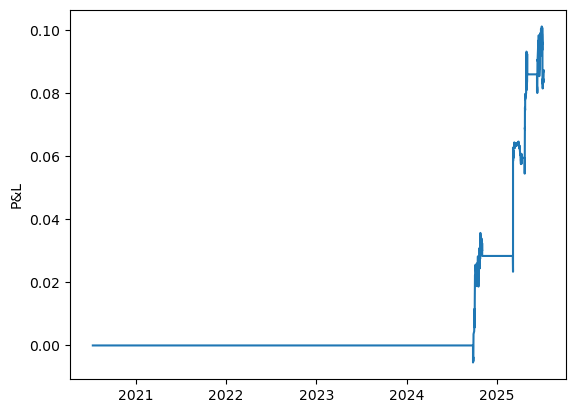

{'CBAWBC': 0.054825468872715395, 'BHPRIO': 0.032101362947699816}

In [18]:
#Result

test_years = [2024,2025]
combine_pair_sims(True, pairs_dates_data, pairs_sim_data, 0.085, test_years)

#
#
#
#
#
#
#
#
#
#
# Results

- The strategy seems profitable for these pairs. However, the test sample is small and the profitability isn't replicable for smaller Australian stocks (partly due to their higher bid-ask spread) or large US pairs. 
- Its parameter optimisation procedure essentially selects reversal/swing trading parameters. Alternative parameter optimisation procedures using Sharpe Ratio or annualised returns were considered. These yielded higher frequency trading strategies which performed less impressively. For example, strategies with daily mean reversion trades had a 1 Sharpe.

# Appendix: Mean Reversion Algorithm

Let’s call ‘ratio’ the price ratio between similar stocks which is observed in the market over time. Imagine a time series graph of ‘ratio’. Now, imagine that there is a symmetrical corridor around the current ‘ratio’ value in the time series graph. We’ll let the width of the entire corridor be 2 * ‘offset’ where ‘offset’ is the algorithm’s tuneable parameter. We’re going to trade if a future ‘ratio’ value hits the corridor on either side. To trade, we will spend a certain amount going long on one of the stocks and the same amount going short on the other stock. Next, we will retreat the centre of the corridor in the direction ‘ratio’ has just moved by the value ‘offset’. This brings us back to square one where the algorithm repeats. For example, if the current 'ratio' is 1 and our offset value is 0.05 then we would trade when the ratio value reaches 1.05. The algorithm would autonomously close this trade (taking profit) if the ratio returns to 1. If the ratio value reached 1.1 it would bet on a reversal once again, doubling down. This could continue indefintiely and would make money if the pair's price ratio mean reverts more often than not.